In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import PIL
import os
from PIL import Image, ImageOps
import glob
import cv2

In [ ]:
data =os.listdir('/content/drive/MyDrive/Dataset/Wayangs') 

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  
  %tensorflow_version 2.x
except Exception:
  pass
import numpy as np 
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf 
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


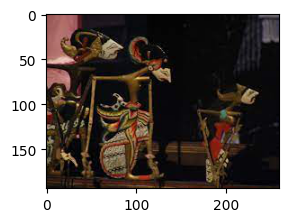

In [ ]:
image = imread('/content/drive/MyDrive/Dataset/Wayangs/train/wayang_krucil/10_Krucil.jpg')
plt.figure(figsize=(3,3))
plt.imshow(image)


In [ ]:

IMAGE_SIZE = 224 
BATCH_SIZE = 128 
base_dir = os.path.join('/content/drive/MyDrive/Dataset/Wayangs/train')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')


X_test = []
y_test = []
labels = ['wayang_beber', 'wayang_gedog', 'wayang_golek','wayang_krucil', 'wayang_kulit', 'wayang_suluh']

for i,label in enumerate(labels):
    folder = os.path.join("/content/drive/MyDrive/Dataset/Wayangs/test",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(224,224))
        X_test.append(image) 
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)


for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)

Found 144 images belonging to 6 classes.
Found 35 images belonging to 6 classes.
Bentuk array dari dataset train (pelatihan) adalah: (128, 224, 224, 3) (128, 6)
Bentuk array dari dataset validation (validasi) adalah: (35, 224, 224, 3) (35, 6)
Bentuk array dari dataset test (pengujian) adalah: (53, 224, 224, 3) (53,)


In [ ]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'wayang_beber': 0, 'wayang_gedog': 1, 'wayang_golek': 2, 'wayang_krucil': 3, 'wayang_kulit': 4, 'wayang_suluh': 5}


In [ ]:
!cat labels.txt

wayang_beber
wayang_gedog
wayang_golek
wayang_krucil
wayang_kulit
wayang_suluh

In [ ]:
IMG_SHAPE = (224, 224, 3)

base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

17225924/17225924 [==============================] - 2s 0us/step


In [ ]:
base_model.trainable = False
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [ ]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping , ModelCheckpoint,ReduceLROnPlateau
import h5py
from sklearn.model_selection import train_test_split

In [ ]:
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test, y_test2)

In [ ]:
model = tf.keras.Sequential([
    base_model,    
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.summary() 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 32)          294944    
                                                                 
 global_average_pooling2d_1   (None, 32)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                                 
Total params: 3,524,006
Trainable params: 295,142
Non-trainable params: 3,228,864
_________________________________________________________________


In [ ]:
model.compile("adam",loss="categorical_crossentropy",metrics=["accuracy"])


In [ ]:
erl_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
mod_chk= ModelCheckpoint(filepath='/content/drive/MyDrive/Dataset/model/my_model.hdf5',monitor='val_loss',save_best_only=True)
lr_rate= ReduceLROnPlateau(monitor='val_loss', patience=3 , factor=0.1)

In [ ]:

history = model.fit_generator(train_generator, 
                    epochs=50, 
                    shuffle=True,
                    validation_data=val_generator,
                    callbacks=[erl_stop,mod_chk,lr_rate],verbose=2)


<ipython-input-17-614959f10df7>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/50
2/2 - 20s - loss: 3.0862 - accuracy: 0.1389 - val_loss: 1.6326 - val_accuracy: 0.4571 - lr: 0.0010 - 20s/epoch - 10s/step
Epoch 2/50
2/2 - 13s - loss: 1.0761 - accuracy: 0.5694 - val_loss: 0.9239 - val_accuracy: 0.7143 - lr: 0.0010 - 13s/epoch - 7s/step
Epoch 3/50
2/2 - 12s - loss: 0.8626 - accuracy: 0.6736 - val_loss: 0.9340 - val_accuracy: 0.5429 - lr: 0.0010 - 12s/epoch - 6s/step
Epoch 4/50
2/2 - 15s - loss: 0.8150 - accuracy: 0.5972 - val_loss: 0.9196 - val_accuracy: 0.5429 - lr: 0.0010 - 15s/epoch - 7s/step
Epoch 5/50
2/2 - 12s - loss: 0.7609 - accuracy: 0.6250 - val_loss: 0.8934 - val_accuracy: 0.6000 - lr: 0.0010 - 12s/epoch - 6s/step
Epoch 6/50
2/2 - 10s - loss: 0.6269 - accuracy: 0.7917 - val_loss: 0.7464 - val_accuracy: 0.7714 - lr: 0.0010 - 10s/epoch - 5s/step
Epoch 7/50
2/2 - 11s - loss: 0.4931 - accuracy: 0.8403 - val_loss: 0.6225 - val_accuracy: 0.7714 - lr: 0.0010 - 11s/epoch - 6s/step
Epoch 8/50
2/2 - 12s - loss: 0.3751 - accuracy: 0.8750 - val_loss: 0.6665 -

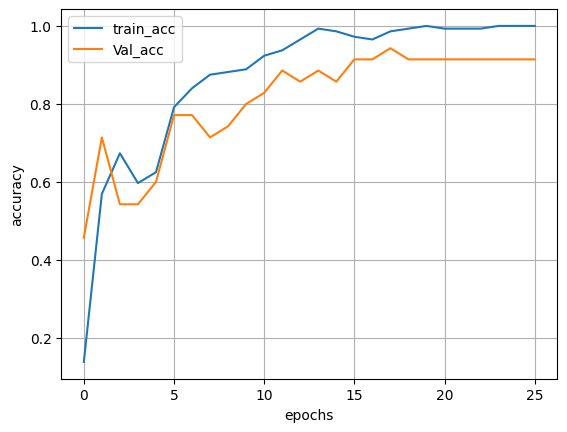

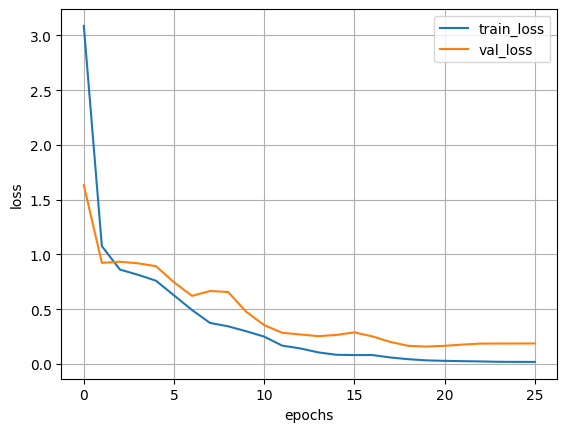

In [ ]:
plt.plot(history.history["accuracy"],label="train_acc")
plt.plot(history.history["val_accuracy"],label="Val_acc")
plt.grid()
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.show()

plt.plot(history.history["loss"],label="train_loss")
plt.plot(history.history["val_loss"],label="val_loss")
plt.grid()
plt.legend()
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

In [ ]:
model.evaluate(x= X_test3, y = y_test3,steps=len(X_test3),verbose=2)



53/53 - 2s - loss: 0.4487 - accuracy: 0.7736 - 2s/epoch - 45ms/step


[0.44871851801872253, 0.7735849022865295]